In [51]:
import cv2
import numpy as np
import math
import utils
from plyfile import PlyData, PlyElement
import subprocess
import json
import os
import shutil
pi = 3.14159265

def run_openpose(imdir, outdir):
    command = ['/home/vaheta/builds/openpose/build/examples/openpose/openpose.bin', 
            '--image_dir', imdir, 
            '--face', 
            '--net_resolution', '656x368', 
            '--write_json', outdir,
            '--write_images', outdir,
            '--display', '0']
    subprocess.call(command)
    
def read_keypoint_jsons(jsondir):
    faces = {}
    for filename in os.listdir(jsondir):
        if filename.endswith(".json"):
            with open((jsondir+'/'+filename)) as f:
                data = json.load(f)
                tempdict = {'x':[], 'y':[], 'c':[]}
                for i,k in enumerate(data['people'][0]['face_keypoints_2d']):
                    if i%3==0:
                        tempdict['x'].append(k)
                    elif i%3==1:
                        tempdict['y'].append(k)
                    elif i%3==2:
                        tempdict['c'].append(k)
                faces[filename[0:-15]] = tempdict
    return faces

In [52]:
# Set paths to stereo files here:

imgL_path = 'face_render/facex005.png'
imgR_path = 'face_render/face0.png'

procdir = '/home/vaheta/dpolar/for_processing'


if os.path.isdir(procdir):
    shutil.rmtree(procdir)
os.makedirs(procdir)

shutil.copyfile(imgL_path, (procdir+'/imgl.png'))
shutil.copyfile(imgR_path, (procdir+'/imgr.png'))

run_openpose(procdir,procdir)
faces = read_keypoint_jsons(procdir)

In [33]:
faces

{'imgl': {'c': [0.678843,
   0.71491,
   0.730194,
   0.703085,
   0.648399,
   0.710207,
   0.68572,
   0.772472,
   0.754681,
   0.784573,
   0.830789,
   0.751288,
   0.723348,
   0.774655,
   0.819084,
   0.87513,
   0.901721,
   0.644179,
   0.833867,
   0.841757,
   0.843531,
   0.770707,
   0.841321,
   0.855831,
   0.857005,
   0.778193,
   0.676846,
   0.884187,
   0.882417,
   0.917629,
   0.89537,
   0.910732,
   0.965401,
   0.898589,
   0.93775,
   0.890569,
   0.88682,
   0.908154,
   0.929294,
   0.922215,
   0.926813,
   0.932397,
   0.892846,
   0.938294,
   0.975504,
   0.915688,
   0.96991,
   0.945408,
   0.876893,
   0.883899,
   0.861975,
   0.956989,
   0.879072,
   0.940962,
   0.956203,
   0.945434,
   0.90336,
   0.919708,
   0.861675,
   0.857095,
   0.912786,
   0.863556,
   0.922856,
   0.898531,
   0.932267,
   0.895551,
   0.940087,
   0.871397,
   0.808632,
   0.939655],
  'x': [358.452,
   358.452,
   360.666,
   366.201,
   380.592,
   404.945,
   435.

In [47]:
disp = np.zeros((1000,1000))
N = len(faces['imgl']['x'])
for i in range(0,N):
    xl = faces['imgl']['x'][i]
    yl = faces['imgl']['y'][i]
    xr = faces['imgr']['x'][i]
    yr = faces['imgr']['y'][i]
    disp[int(yr),int(xr)] = xl-xr

<IPython.core.display.Javascript object>


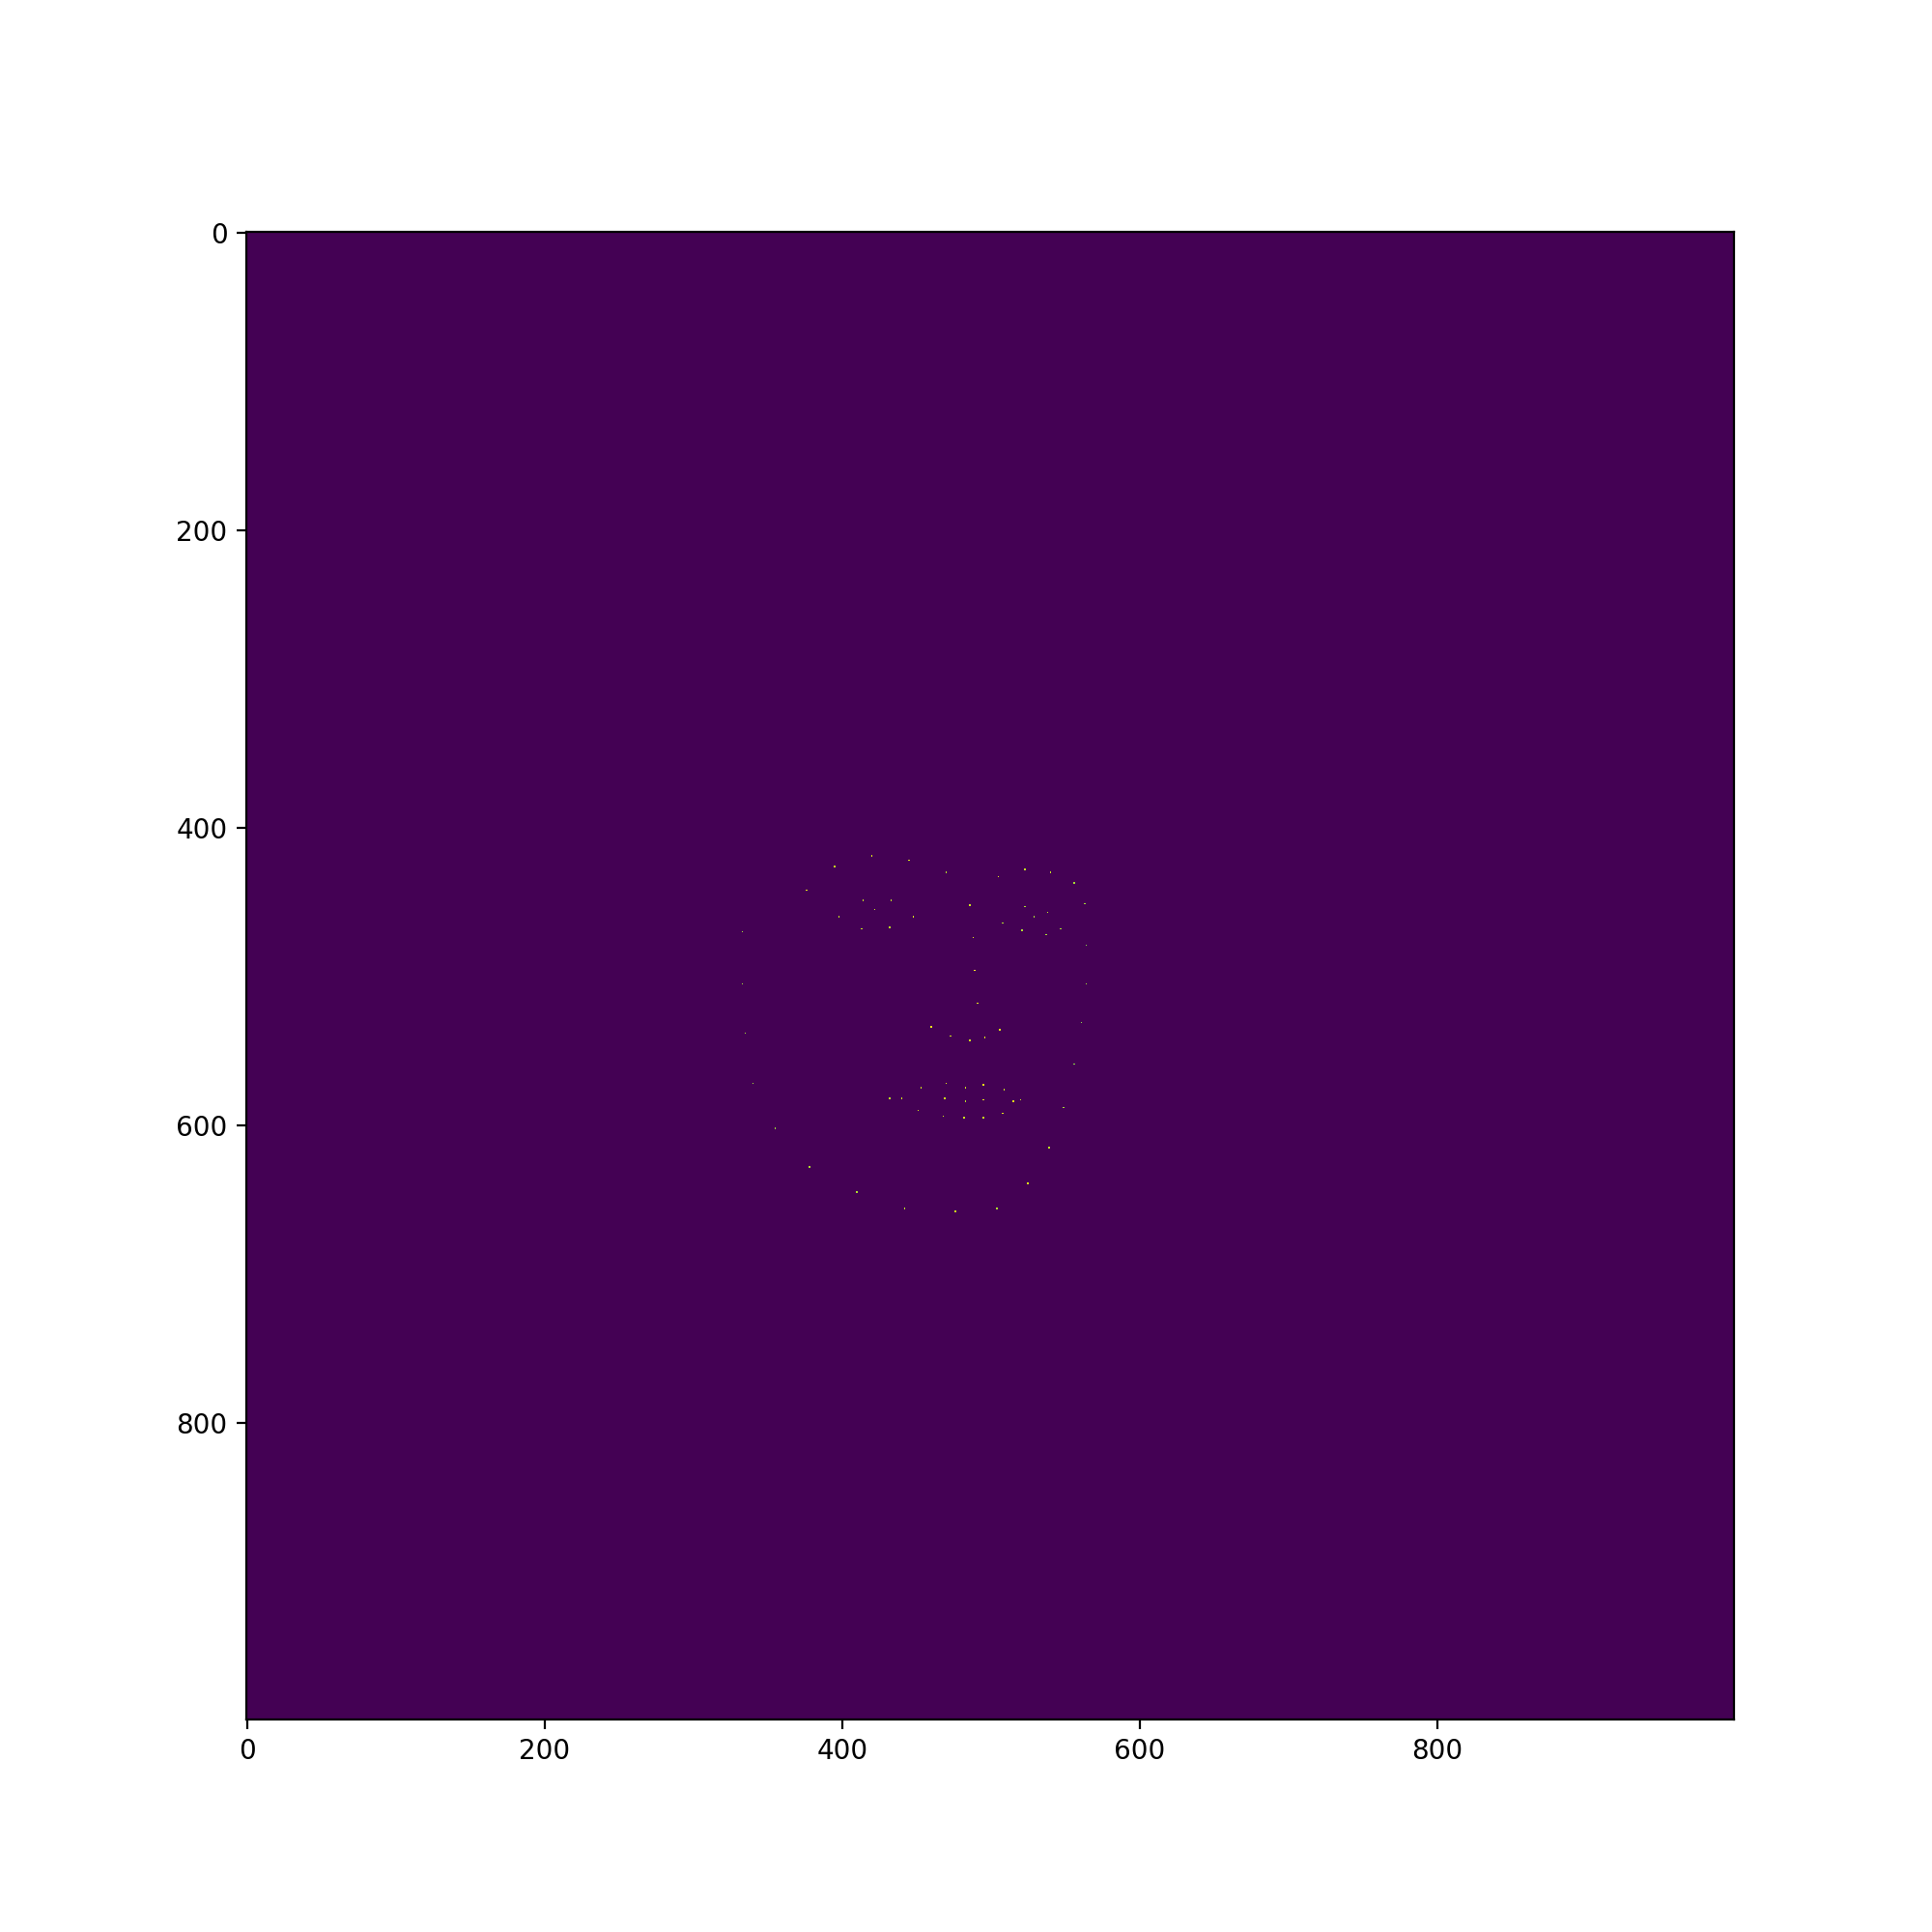

In [48]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.figure(figsize=(10,10))
plt.imshow(disp)
plt.show()

In [50]:
def disp2pc (disp):
    xs = np.zeros((disp.shape[0]*disp.shape[1], 1))
    ys = np.zeros((disp.shape[0]*disp.shape[1], 1))
    zs = np.zeros((disp.shape[0]*disp.shape[1], 1))
    i = 0
    for x in range(0, disp.shape[1]):
        for y in range(0, disp.shape[0]):
            if (disp[y,x]>20):
                xs[i] = x
                ys[i] = y
                zs[i] = disp[y,x]
                i = i + 1
    return (xs,ys,zs)

xs,ys,zs = disp2pc(disp)

arr = np.hstack((xs,ys,zs))

N = len(arr)
fa = np.array([(arr[0,0], arr[0,1], arr[0,2])], dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')])  
for i in range(1,N):
    if (arr[i,0]==0): 
        continue
    fatempest = np.array([(arr[i,0], arr[i,1], arr[i,2])], dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')])
    fa = np.append(fa, fatempest)
    
el = PlyElement.describe(fa, 'vertex')
PlyData([el], text=True).write('some_binary.ply')